In [9]:
import keras
import tensorflow as tf
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import pandas as pd
import collections
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import sklearn
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Activation, Flatten,Embedding,SimpleRNN, LSTM,Conv1D,MaxPooling1D
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.metrics import roc_curve
from keras.applications import VGG16, ResNet50
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from keras.applications import VGG16, ResNet50
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model

# 1 Autoencoder

In [16]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [11]:
input_img = Input(shape=(784,))
encoded = Dense(32, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

In [12]:
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [13]:
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

In [17]:
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 81us/step - loss: 0.3747 - val_loss: 0.3241
Epoch 2/5
60000/60000 [==============================] - 3s 46us/step - loss: 0.3112 - val_loss: 0.3047
Epoch 3/5
60000/60000 [==============================] - 3s 46us/step - loss: 0.2971 - val_loss: 0.2951
Epoch 4/5
60000/60000 [==============================] - 3s 47us/step - loss: 0.2904 - val_loss: 0.2905
Epoch 5/5
60000/60000 [==============================] - 3s 53us/step - loss: 0.2873 - val_loss: 0.2886


In [18]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

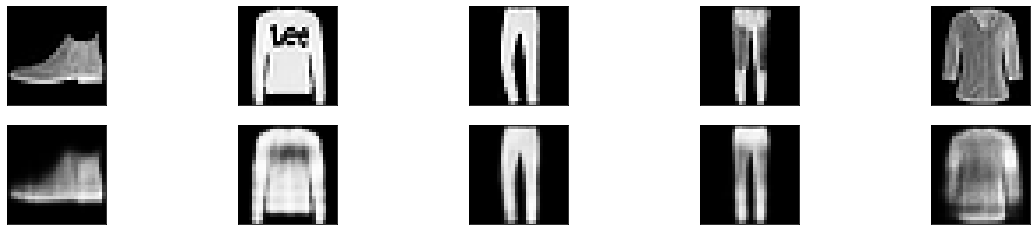

In [20]:
import matplotlib.pyplot as plt
n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 2 Image Classification
## 2.1 Deep CNN

The parameters I choose are:
 - Kernel Size = (3,3)
 - Network Depth = 4
 - Stride Size = 1
 - Valid Padding

Performance:
 - Train(Average) = 0.9019
 - Test = 0.9075

In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [24]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [164]:
model = Sequential()
model.add(keras.layers.Conv2D(filters = 28, kernel_size = (3,3), strides=1,
  padding = "valid", input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
history = model.fit(x=x_train,y=y_train, epochs=5,batch_size = 32, 
                    verbose=1)

Epoch 1/5
60000/60000 [==============================] - 41s 680us/step - loss: 0.4171 - accuracy: 0.8507
Epoch 2/5
60000/60000 [==============================] - 40s 666us/step - loss: 0.2864 - accuracy: 0.8949
Epoch 3/5
60000/60000 [==============================] - 38s 626us/step - loss: 0.2425 - accuracy: 0.9100
Epoch 4/5
60000/60000 [==============================] - 37s 623us/step - loss: 0.2103 - accuracy: 0.9226
Epoch 5/5
60000/60000 [==============================] - 42s 706us/step - loss: 0.1864 - accuracy: 0.9314s - loss: 0.1863 - accura


In [165]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 176us/step


[0.2639208701014519, 0.9075000286102295]

## 2.2 Transfer Learning

Performance(Accuracy):
 - Train(Average) = 0.8208
 - Test = 0.8406

In [2]:
## convert gray scale image to rgv
def to_rgb(img):
    img= K.expand_dims(img, axis=-1)
    tiling = [1] * 4    
    tiling[-1] *= 3
    img= K.tile(img, tiling)
    return img
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28)
X_test = X_test.reshape(X_test.shape[0], 28, 28)
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
x_train = to_rgb(X_train)
x_train = tf.image.resize(x_train, [32, 32])
x_test = to_rgb(X_test)
x_test = tf.image.resize(x_test, [32, 32])
sess = tf.Session()
x_train = sess.run(x_train)
x_test= sess.run(x_test)

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(32,32,3))
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(10, activation="sigmoid"))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 14,752,330
Trainable params: 14,752,330
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss="categorical_crossentropy", optimizer='Adam',metrics=["acc"])

In [7]:
model.fit(x_train, Y_train, epochs=5, batch_size = 128)

Epoch 1/5
60000/60000 [==============================] - 627s 10ms/step - loss: 0.8433 - acc: 0.6960
Epoch 2/5
60000/60000 [==============================] - 639s 11ms/step - loss: 0.4663 - acc: 0.8326
Epoch 3/5
60000/60000 [==============================] - 586s 10ms/step - loss: 0.4104 - acc: 0.8495
Epoch 4/5
60000/60000 [==============================] - 654s 11ms/step - loss: 0.3751 - acc: 0.8592
Epoch 5/5
60000/60000 [==============================] - 616s 10ms/step - loss: 0.3529 - acc: 0.8668


In [8]:
model.evaluate(x_test, Y_test)

10000/10000 [==============================] - 114s 11ms/step


[0.46603680868148806, 0.8406000137329102]

# 3 Text Classification
## 3.1 RNN

In [4]:
filepath = '/Users/zmt/Desktop/tweets_with_labels.txt'
dic = collections.defaultdict(list)
with open(filepath) as fp:
    title = fp.readline()
    title = title.split()
    line = fp.readline()
    line = line[1:len(line)-1]
    while line:
        line = line.split()
        for i in range(len(line)-1,len(line)-16,-1):
            num = line[i]
            if num.isnumeric():
                dic[len(line)-i-1].append(float(num))
            else:
                dic[len(line)-i-1].append(float(num[:-1]))
        dic['tweet'].append(' '.join(line[1:len(line)-15]))
        line = fp.readline()

In [5]:
data = pd.DataFrame(dic)

In [6]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,tweet
0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jazz for a Rainy Afternoon: {link}
1,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RT: @mention: I love rainy days.
2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Good Morning Chicago! Time to kick the Windy C...
3,0.0,0.0,0.2,0.0,0.0,0.0,0.19,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,Preach lol! :) RT @mention: #alliwantis this t...
4,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,@mention good morning sunshine


In [64]:
data.shape

(77946, 16)

In [13]:
def clean_tweet(text):
    text = text.lower()
    #add filler into stop words
    stop_words = set(stopwords.words('english'))
    punctuation = set(list(string.punctuation) + ['…', '...','’','``',"''",'–','“',"n't",'”'])
    text = re.sub('#', '',text)
    text = re.sub(r'[-\.\n]', '',text)
    text = re.sub(r'&\w+;','',text)
    # Removing links
    text = re.sub(r'https?://\S*', '',text)
    text = text.replace('[^\w\s]','')
    word_tokens = word_tokenize(text)
    filtered_text=[]
    #looping through conditions
    for w in word_tokens:
    #check if w is punctuation or stop_word or numbers
        if w not in punctuation and w not in stop_words and w[0]!='#' and w[0]!='@':
            filtered_text.append(w)
    return ' '.join(filtered_text)

In [14]:
data['clean_tweet'] = [clean_tweet(t) for t in data.tweet]

In [16]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,tweet,clean_tweet
0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jazz for a Rainy Afternoon: {link},jazz rainy afternoon link
1,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RT: @mention: I love rainy days.,rt mention love rainy days
2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Good Morning Chicago! Time to kick the Windy C...,good morning chicago time kick windy city nuts...
3,0.0,0.0,0.2,0.0,0.0,0.0,0.19,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,Preach lol! :) RT @mention: #alliwantis this t...,preach lol rt mention alliwantis type weather ...
4,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,@mention good morning sunshine,mention good morning sunshine


In [17]:
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(data.clean_tweet)
sequences = tokenizer.texts_to_sequences(data.clean_tweet)
x = pad_sequences(sequences, maxlen=180)

In [20]:
y = data[[i for i in range(15)]]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000)

In [32]:
model = Sequential()
model.add(Embedding(max_features, max_len))
model.add(LSTM(32))
model.add(Dense(15, activation ='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 24)          240000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                7296      
_________________________________________________________________
dense_3 (Dense)              (None, 15)                495       
Total params: 247,791
Trainable params: 247,791
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train, 
                    epochs = 10, batch_size = 64, 
                    validation_split = 0.2,verbose=1)

/usr/local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 49884 samples, validate on 12472 samples
Epoch 1/10
49884/49884 [==============================] - 112s 2ms/step - loss: 0.2083 - acc: 0.8821 - val_loss: 0.1564 - val_acc: 0.8970
Epoch 2/10
49884/49884 [==============================] - 116s 2ms/step - loss: 0.1343 - acc: 0.9057 - val_loss: 0.1190 - val_acc: 0.9105
Epoch 3/10
49884/49884 [==============================] - 111s 2ms/step - loss: 0.1155 - acc: 0.9106 - val_loss: 0.1091 - val_acc: 0.9124
Epoch 4/10
49884/49884 [==============================] - 112s 2ms/step - loss: 0.1051 - acc: 0.9135 - val_loss: 0.1042 - val_acc: 0.9134
Epoch 5/10
49884/49884 [==============================] - 113s 2ms/step - loss: 0.1001 - acc: 0.9146 - val_loss: 0.1029 - val_acc: 0.9136
Epoch 6/10
49884/49884 [==============================] - 114s 2ms/step - loss: 0.0971 - acc: 0.9150 - val_loss: 0.1023 - val_acc: 0.9136
Epoch 7/10
49884/49884 [==============================] - 114s 2ms/step - loss: 0.0964 - acc: 0.9148 - val_loss: 0.0992 - 

In [34]:
model.evaluate(x_test, y_test)

15590/15590 [==============================] - 16s 1ms/step


[0.09878393145824106, 0.9137952327728271]

## 3.2 CNN

In [43]:
model_cnn = Sequential()
model_cnn.add(Embedding(10000, input_length = 180, output_dim = 32))
model_cnn.add(Conv1D(32, 3,activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Conv1D(64, 5, activation='relu'))
model_cnn.add(Flatten())    
model_cnn.add(Dense(15, activation ='sigmoid'))
model_cnn.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics=['acc'])
history1 = model_cnn.fit(x_train, y_train, 
                    epochs = 5, batch_size = 32, 
                    verbose=1)

/usr/local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
62356/62356 [==============================] - 60s 964us/step - loss: 0.1529 - acc: 0.8999
Epoch 2/5
62356/62356 [==============================] - 57s 911us/step - loss: 0.1141 - acc: 0.9113
Epoch 3/5
62356/62356 [==============================] - 59s 948us/step - loss: 0.1061 - acc: 0.9131
Epoch 4/5
62356/62356 [==============================] - 63s 1ms/step - loss: 0.1022 - acc: 0.9140
Epoch 5/5
62356/62356 [==============================] - 64s 1ms/step - loss: 0.0996 - acc: 0.9145


In [44]:
model_cnn.evaluate(x_test, y_test)

15590/15590 [==============================] - 3s 196us/step


[0.10177101145060571, 0.9135810732841492]

## 3.3 Comparison

As we have mentioned in 3.1 and 3.2, we get the result of accuracies for two models:
 - LSTM: Average Train Accuracy = 0.9112, Test Accuracy = 0.9138
 - CNN: Average Train Accuracy = 0.9105, Test Accuracy = 0.9136

In [126]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(15):
    pred = [j == max(y_test.iloc[i]) for j in y_test.iloc[i]]
    fpr[i], tpr[i], _ = roc_curve(pred, np.array(y_pred[i]))
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()
for i in range(15):
    pred = [j == max(y_test.iloc[i]) for j in y_test.iloc[i]]
    fpr1[i], tpr1[i], _ = roc_curve(pred, np.array(y_pred1[i]))
    roc_auc1[i] = auc(fpr1[i], tpr1[i])

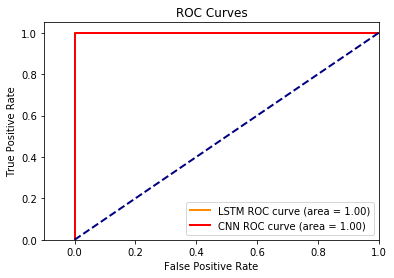

In [186]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot(fpr1[2], tpr1[2], color='red',
         lw=lw, label='CNN ROC curve (area = %0.2f)' % roc_auc[3])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

Overall, two models gave same results for this data. LSTM performed slightly better.